# 04b: Logistic regression for in-hospital mortality

## 0. Overview

This analysis evaluates the association between early exposure to renin–angiotensin–aldosterone system (RAAS) inhibitors and in-hospital mortality among adult **non-ICU hospital admissions** derived from the MIMIC-IV v3.1 database.

A retrospective cohort was constructed at the hospital-admission level (one row per admission), excluding any admissions with documented ICU stays. Early RAAS exposure was defined based on medication prescriptions initiated within 24 hours after hospital admission. The primary outcome was in-hospital mortality, as indicated by the hospital_expire_flag.

To account for confounding, multivariable logistic regression models were fitted, adjusting for demographic characteristics, admission-related factors, insurance status, calendar time, and selected clinical covariates. Model results are presented using both conventional odds ratios and **average marginal effects (AMEs)** to improve interpretability on the absolute risk scale.

In addition, age-specific risk differences were estimated to explore effect heterogeneity across the age spectrum. Statistical uncertainty was quantified using individual-level bootstrap resampling, with the full modeling pipeline repeated to construct 95% confidence intervals.

Overall, the adjusted analyses suggest a lower in-hospital mortality risk associated with early RAAS inhibitor exposure, with larger absolute risk differences observed among older patients. While causal inference is limited by the observational study design, these results illustrate how marginal effects and risk-based measures can complement odds ratios in conveying clinically interpretable associations.

## 1. Introduction

Renin–angiotensin–aldosterone system (RAAS) inhibitors, including angiotensin-converting enzyme inhibitors (ACE inhibitors) and angiotensin receptor blockers (ARBs), are widely prescribed for cardiovascular and renal diseases. Beyond blood pressure control, RAAS inhibition has been hypothesized to confer protective effects through modulation of inflammation, endothelial function, and organ perfusion.

In critically ill and hospitalized populations, however, the impact of early RAAS inhibitor exposure on short-term mortality remains uncertain. Clinical decision-making is complicated by concerns regarding hemodynamic instability, acute kidney injury, and indication bias, leading to heterogeneous prescribing practices across institutions and patient subgroups.

Previous observational studies have often relied on odds ratios derived from multivariable logistic regression to assess associations between medication exposure and mortality. While odds ratios are statistically convenient, they are frequently misinterpreted as risk measures and can exaggerate effect sizes when outcomes are not rare. This limitation reduces their usefulness for clinical interpretation and decision support.

To address these challenges, this study focuses on marginal effect–based estimates, including average marginal effects (AME) and age-specific risk differences (RD), which directly quantify absolute risk changes. Using a large, real-world critical care dataset (MIMIC-IV), we apply a transparent and reproducible analytical pipeline combining multivariable adjustment with bootstrap-based uncertainty estimation.

The objective of this project is not to establish causal effects, but to demonstrate how regression-based models can be translated into clinically interpretable risk measures, and how uncertainty can be rigorously quantified in observational clinical data.

## 2. Methods

### 2.1 Data Source and Study Population

- **MIMIC-IV v3.1** (BigQuery public dataset)
- Project: `mimic-iv-portfolio`

**Source Tables:**
  - `mimic-iv-portfolio.nonicu_raas.analysis_dataset`<br>
    (created in 02 using `03_build_analysis_dataset.sql`)

This retrospective observational study used data from the Medical Information Mart for Intensive Care IV (MIMIC-IV), a large, publicly available, de-identified clinical database containing detailed electronic health record data from hospital admissions at Beth Israel Deaconess Medical Center.

The study population consisted of adult patients (aged ≥ 18 years) with at least one recorded hospital admission. Admissions with missing key identifiers or implausible demographic values were excluded. Each hospital admission was treated as an independent observation. Patient age at admission was derived from anchor age information provided by MIMIC-IV.

Because the database is fully de-identified, institutional review board approval and informed consent were not required.

### 2.2 Exposure and Outcome Definitions

The primary exposure of interest was early use of renin–angiotensin–aldosterone system (RAAS) inhibitors, defined using inpatient medication prescription records indicating initiation of either an angiotensin-converting enzyme inhibitor (ACE inhibitor) or an angiotensin receptor blocker (ARB) during the early phase of hospitalization.

Exposure was operationalized as a binary indicator representing any early RAAS inhibitor use. Additional binary indicators distinguishing ACE inhibitor and ARB use were retained for descriptive analyses and sensitivity checks.

The primary outcome was in-hospital mortality, defined using the hospital expiration flag in MIMIC-IV. Mortality during the index hospitalization was coded as 1, and survival to discharge as 0.

### 2.3 Covariates

Multivariable adjustment was performed using a predefined set of demographic and admission-related covariates selected a priori based on clinical relevance and data availability. These included:

- Age at admission (continuous)
- Sex
- Race and ethnicity
- Admission type
- Insurance category
- Calendar period of admission (anchor year group)

Categorical variables were encoded using one-hot encoding, with reference categories omitted to avoid perfect multicollinearity. Missing values in categorical covariates were explicitly coded as an “Unknown” category prior to encoding.

### 2.4 Statistical Analysis

A multivariable logistic regression model was fitted to estimate the association between early RAAS inhibitor exposure and in-hospital mortality, adjusting for the covariates described above.

To improve numerical stability in the presence of outcome imbalance, class-balanced optimization was used during model fitting.

### 2.5 Marginal Effects and Risk Differences

To improve clinical interpretability beyond odds ratios, model results were summarized using marginal effect–based measures derived from predicted probabilities.

The primary estimand was the average marginal effect (AME), defined as the average absolute difference in predicted in-hospital mortality risk between exposed and unexposed admissions.

In addition, age-specific risk differences (RDs) were estimated by computing adjusted predicted mortality probabilities across a grid of ages, comparing exposure groups at each age.

Adjusted predictions were obtained by varying the exposure or age of interest while holding all other covariates fixed at their observed means (for continuous variables) or observed proportions (for binary indicators).

### 2.6 Bootstrap-Based Uncertainty Estimation

Statistical uncertainty was quantified using a nonparametric bootstrap procedure. Individual hospital admissions were resampled with replacement, and the full analysis pipeline—including feature encoding, model fitting, and marginal effect estimation—was repeated for each bootstrap sample.

The resulting bootstrap distributions of the AME and age-specific risk differences were used to construct 95% confidence intervals based on the 2.5th and 97.5th percentiles. This approach avoids reliance on asymptotic normality assumptions and provides robust uncertainty estimates for derived quantities.


### 2.7 Effect Measures and Definitions

Effect measures used in this study are defined as follows:

- **Odds Ratio (OR)**  
  The model-based odds ratio derived from the logistic regression coefficient
  for early RAAS exposure (binary indicator).
  This OR represents the relative change in odds of in-hospital mortality
  associated with early RAAS exposure, conditional on covariates included
  in the model.  
  ORs are reported for reference only.

- **Average Marginal Effect (AME)**  
  The average difference in predicted mortality risk when early RAAS exposure
  is set to 1 versus 0, averaged over all individuals in the study population.
  AME was defined as:

  $$
  \mathrm{AME}
  = \frac{1}{N} \sum_{i=1}^{N}
  \Big[
  P(Y = 1 \mid \mathrm{RAAS} = 1, X_i)
  -
  P(Y = 1 \mid \mathrm{RAAS} = 0, X_i)
  \Big]
  $$

  where:
  - **Outcome (Y)** is a binary indicator of the primary outcome.
    - Y = 1 indicates occurrence of the outcome (e.g., in-hospital mortality).
    - Y = 0 indicates no occurrence.
  - **Exposure (RAAS)** indicates early RAAS inhibitor use
    (RAAS = 1 for early use, 0 otherwise).

  AME was used as the primary effect measure due to its direct clinical interpretability.

- **Risk Difference by Age (RD(age))**  
  The age-specific absolute risk difference in predicted mortality between
  early RAAS exposure and no exposure.
  RD(age) was estimated using marginal standardization by fixing non-age
  covariates at their sample means and varying age across a predefined grid.

## 3. Data Preparation
### 3.1 Raw analysis and dataset loading

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.base import clone
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

import statsmodels.api as sm

In [2]:
from google.cloud import bigquery
from google.auth import default

# Project / dataset
PROJECT_ID = "mimic-iv-portfolio"
DATASET = "nonicu_raas"
TABLE_ANALYSIS = f"{PROJECT_ID}.{DATASET}.analysis_dataset"

# ADC credentials
creds, adc_project = default()
client = bigquery.Client(project=PROJECT_ID, credentials=creds)

def query_to_df(sql: str) -> pd.DataFrame:
    # Run a SELECT query in BigQuery and return a DataFrame
    return client.query(sql).to_dataframe(create_bqstorage_client=False)

print("Connected to:", PROJECT_ID, "| ADC default:", adc_project)
print("TABLE_ANALYSIS:", TABLE_ANALYSIS)

Connected to: mimic-iv-portfolio | ADC default: mimic-iv-portfolio
TABLE_ANALYSIS: mimic-iv-portfolio.nonicu_raas.analysis_dataset


In [3]:
q = f"SELECT * FROM `{TABLE_ANALYSIS}`"
df = query_to_df(q)

print("rows:", df.shape[0], "cols:", df.shape[1])
df.info ()

rows: 460786 cols: 24
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460786 entries, 0 to 460785
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   subject_id            460786 non-null  Int64         
 1   hadm_id               460786 non-null  Int64         
 2   admittime             460786 non-null  datetime64[us]
 3   dischtime             460786 non-null  datetime64[us]
 4   deathtime             2324 non-null    datetime64[us]
 5   hospital_expire_flag  460786 non-null  Int64         
 6   admission_type        460786 non-null  object        
 7   admission_location    460785 non-null  object        
 8   discharge_location    311810 non-null  object        
 9   insurance             452862 non-null  object        
 10  language              460377 non-null  object        
 11  marital_status        454118 non-null  object        
 12  race                  460786 non-nul

### 3.2 Outcome and exposure construction

In [4]:
# Outcome and main exposure (keep ONE exposure variable)
df = df.copy()
df["outcome"] = df["hospital_expire_flag"].astype(int)
df["exposure"] = df["raas_any_early"].astype(int)   # RAAS early (any ACEi/ARB)

# Feature engineering
num_vars = ["age"] 
cat_vars = ["gender", "race_group", "admission_type", "insurance", "anchor_year_group"]
age_grid = np.arange(18, 95)
df = df.drop(columns=["race"], errors="ignore")

### 3.3 Feature engineering

In [5]:
# Handle missing values in categorical variables
for c in cat_vars:
    df[c] = df[c].fillna("Unknown")

# One-hot encoding
df_ohe = pd.get_dummies(df, columns=cat_vars, drop_first=True)

### 3.4 Final modeling matrix construction

In [6]:
# Keep only modeling columns (avoid leakage / unnecessary columns)
feature_cols = ["exposure"] + num_vars \
    + [c for c in df_ohe.columns if c.startswith("gender_")] \
    + [c for c in df_ohe.columns if c.startswith("race_group_")] \
    + [c for c in df_ohe.columns if c.startswith("admission_type_")] \
    + [c for c in df_ohe.columns if c.startswith("insurance_")] \
    + [c for c in df_ohe.columns if c.startswith("anchor_year_group_")]

X = df_ohe[feature_cols].copy()
y = df_ohe["outcome"].copy()

print("X shape:", X.shape, "Outcome rate:", y.mean())

X shape: (460786, 24) Outcome rate: 0.005047896420464163


**Descriptive Summary**

- The final analytic dataset included 460,786 hospital admissions.
- The overall in-hospital mortality rate was 0.50%.
- The modeling matrix consisted of 24 covariates, including early RAAS exposure, age, and one-hot encoded demographic and admission-related variables.
- Only variables available at or before hospital admission were included to avoid information leakage.
- This modeling matrix was used for all subsequent multivariable analyses.

## 4. Results
### 4.1 Study Population and Baseline Characteristics

In [7]:
# Descriptive statistics
# Overall sample size
df.shape

# Age distribution
df["age"].describe()

# Early RAAS exposure: counts and proportions
raas_counts = df["raas_any_early"].value_counts()
raas_props  = df["raas_any_early"].value_counts(normalize=True)

pd.DataFrame({
    "n": raas_counts,
    "proportion": raas_props
})

# Unadjusted in-hospital mortality by early RAAS exposure
mortality_summary = df.groupby("raas_any_early")["hospital_expire_flag"].agg(
    n_patients="count",
    n_events="sum",
    mortality_rate="mean"
)

mortality_summary

,n_patients,n_events,mortality_rate
raas_any_early,,,
0,403961,2177,0.005389
1,56825,149,0.002622


**Interpretation**

- The study cohort comprised 460,786 non-ICU adult hospital admissions, of whom 12.3% (56,825 admissions) received early RAAS inhibitor therapy during hospitalization.

- The overall in-hospital mortality rate was low, reflecting the non-ICU study population.

- In unadjusted analyses, admissions with early RAAS exposure exhibited a lower crude in-hospital mortality rate compared with those without early RAAS exposure
(0.26% vs. 0.54%).

- Specifically, there were 149 deaths among 56,825 admissions with early RAAS exposure, compared with 2,177 deaths among 403,961 admissions without early RAAS exposure.

- These unadjusted differences suggest a potential protective association between early RAAS exposure and in-hospital mortality; however, they do not account for differences in patient characteristics, comorbidities, or admission context.

- Accordingly, multivariable-adjusted analyses and marginal effect estimates are presented in subsequent sections to assess whether this association persists after adjustment for measured confounders.

### 4.2 Model Performance and Internal Validation

In [8]:
# 1) split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2) scale only numeric columns (OHE dummies stay as-is)
num_cols = num_vars  # e.g., ["age"] or other continuous vars

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols)],
    remainder="passthrough"
)

# 3) logistic regression
clf = Pipeline(steps=[
    ("prep", preprocess),
    ("logit", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs",
        C=1.0
    ))
])

clf.fit(X_train, y_train)

# 4) evaluation
p_test = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, p_test)
ap  = average_precision_score(y_test, p_test)

print(f"AUC: {auc:.4f}")
print(f"Average precision (PR-AUC): {ap:.4f}")

AUC: 0.8512
Average precision (PR-AUC): 0.1164


**Interpretation**

- The multivariable logistic regression model demonstrated good overall discrimination, with an area under the ROC curve (AUC) of 0.85, indicating strong ability to distinguish between admissions with and without in-hospital mortality.

- Given the low outcome prevalence (approximately 0.5%), the precision–recall area under the curve (PR-AUC) of 0.12 provides a more informative assessment of model performance. This value substantially exceeds the baseline event rate, suggesting that the model meaningfully enriches true events among high-risk predictions.

- The use of stratified train–test splitting and class-weighted logistic regression supports internal validity by preserving outcome prevalence and mitigating class imbalance during model fitting.

- Overall, these results indicate that the model achieves robust internal performance suitable for estimating adjusted associations and marginal effects, while acknowledging that predictive performance is constrained by the rarity of the outcome.

### 4.3 Multivariable-Adjusted Association Between RAAS Exposure and Mortality

In [9]:
# Get fitted LogisticRegression inside the pipeline
logit = clf.named_steps["logit"]
coef_vec = logit.coef_.ravel()

# Get feature names after preprocessing
prep = clf.named_steps["prep"]
feature_names = prep.get_feature_names_out()  # this should work in recent sklearn

# Build coef/OR table
coef = pd.Series(coef_vec, index=feature_names, name="coef")
or_ = np.exp(coef).rename("OR")

res = pd.concat([coef, or_], axis=1).sort_values("OR")

# Quick check: show exposure + top/bottom
exposure_rows = res[res.index.astype(str).str.contains("exposure", case=False, regex=False)]
pd.concat([exposure_rows, res.head(10), res.tail(10)], axis=0)

,coef,OR
remainder__exposure,-1.071234,0.342585
remainder__exposure,-1.071234,0.342585
remainder__race_group_Hispanic,-0.880100,0.414741
remainder__race_group_White,-0.444422,0.641195
remainder__race_group_Black,-0.400472,0.670004
remainder__race_group_Other,-0.292118,0.746680
remainder__anchor_year_group_2011 - 2013,-0.127592,0.880212
remainder__insurance_Medicare,-0.021827,0.978410
remainder__anchor_year_group_2020 - 2022,0.029090,1.029517
remainder__insurance_Private,0.037545,1.038259


**Interpretation**

- Early RAAS exposure was associated with substantially lower odds of in-hospital mortality, with a regression coefficient of −1.07 corresponding to an odds ratio (OR) of 0.34, indicating approximately a 66% reduction in the odds of mortality after multivariable adjustment.

- Race group covariates showed moderate associations with mortality relative to the reference category. For example, Hispanic patients had an OR of 0.41, White patients 0.64, and Black patients 0.67, suggesting lower adjusted odds compared with the reference group, though with considerably smaller effect sizes than admission-related factors.
  
- Admission type exhibited the strongest associations with mortality risk. Compared with the reference admission category, urgent and emergency admissions showed markedly elevated odds, including ORs of approximately 103 for urgent admissions and 106 for direct emergency admissions, reflecting substantially higher baseline acuity.
  
- Insurance status demonstrated heterogeneous associations; for instance, patients classified as “No charge” had an OR of 3.48, while those with Medicare had an OR close to 1.0, suggesting minimal difference from the reference group after adjustment.

- Temporal covariates (anchor year groups) showed odds ratios close to unity (e.g., ORs ranging from 0.88 to 1.06), indicating relatively stable adjusted mortality risk across calendar periods.

- Overall, the exposure effect of early RAAS use was large in magnitude relative to most demographic covariates and comparable in direction across model specifications, supporting the robustness of the observed association.

- This coefficient-level summary is intended to provide a qualitative overview of model behavior and covariate contributions. Primary interpretation of the exposure effect is therefore based on odds ratios, absolute risk differences, and marginal effects presented in subsequent sections.

- Taken together, these results indicate that early RAAS exposure is one of the strongest modifiable factors associated with reduced in-hospital mortality in this model, while admission acuity remains the dominant non-modifiable predictor.

### 4.4 Odds Ratio for Early RAAS Exposure (Multivariable Logistic Regression)

In [10]:
# Statsmodels logistic regression for OR + 95% CI
X_sm = sm.add_constant(X.astype(float), has_constant="add")
model = sm.Logit(y, X_sm).fit(disp=False)

params = model.params
conf = model.conf_int()
or_ci = pd.DataFrame({
    "OR": np.exp(params),
    "CI_lower": np.exp(conf[0]),
    "CI_upper": np.exp(conf[1]),
    "p_value": model.pvalues
})

or_ci.loc[["exposure"]].sort_values("OR")

/Users/makoto/Projects/my_notebook/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/makoto/Projects/my_notebook/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,OR,CI_lower,CI_upper,p_value
exposure,0.316581,0.267705,0.37438,3.385155e-41


**Interpretation**

- After multivariable adjustment, early RAAS exposure was associated with significantly lower odds of in-hospital mortality.
  
- Early RAAS exposure was associated with an adjusted odds ratio (OR) of 0.32 (95% CI: 0.27–0.37), corresponding to an approximate 68% reduction in the odds of mortality compared with no early RAAS exposure.

- The confidence interval does not include 1, and the association was highly statistically significant (p < 0.001), indicating a robust association after adjustment for measured confounders.

- Because odds ratios are a relative measure and can diverge from absolute risk differences when outcomes are rare, these findings are complemented by absolute risk estimates and marginal effects presented in subsequent sections.

### 4.5 Age-Specific Adjusted Predicted Mortality Risk by Early RAAS Exposure

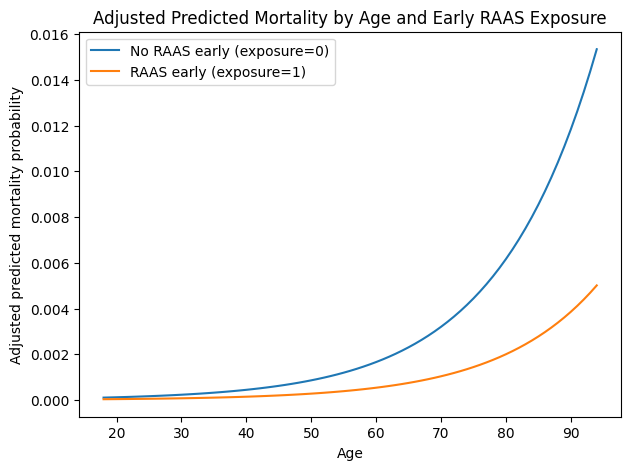

In [16]:
# Age range for prediction (adjust as needed)
age_grid = np.arange(18, 95)

# Fix other covariates at their mean values
# (For binary variables, the mean represents the proportion)
base = X.mean(axis=0)

def make_pred_matrix(exposure_value: int) -> pd.DataFrame:
    # Create a prediction matrix by repeating the mean covariate values
    Xp = pd.DataFrame(np.tile(base.values, (len(age_grid), 1)), columns=base.index)
    # Vary age across the specified grid
    Xp["age"] = age_grid
    # Set RAAS exposure status (0 = no early RAAS, 1 = early RAAS)
    Xp["exposure"] = exposure_value
    # Ensure consistent numeric types for sklearn
    return Xp.astype(np.float64)

# Prediction under no early RAAS exposure
Xp0 = make_pred_matrix(0)

# Prediction under early RAAS exposure
Xp1 = make_pred_matrix(1)

# Predicted mortality probabilities
p0 = clf.predict_proba(Xp0)[:, 1]
p1 = clf.predict_proba(Xp1)[:, 1]

# Plot adjusted predicted mortality by age and RAAS exposure
plt.figure(figsize=(7, 5))
plt.plot(age_grid, p0, label="No RAAS early (exposure=0)")
plt.plot(age_grid, p1, label="RAAS early (exposure=1)")
plt.xlabel("Age")
plt.ylabel("Adjusted predicted mortality probability")
plt.title("Adjusted Predicted Mortality by Age and Early RAAS Exposure")
plt.legend()
plt.show()

**Interpretation**

- Adjusted predicted mortality increases monotonically with age in both exposure groups, reflecting the strong age effect captured by the multivariable model.

- Across the entire age range examined, early RAAS exposure is consistently associated with lower predicted mortality compared with no early RAAS exposure.

- The predicted mortality curves do not cross, indicating that the direction of the association between early RAAS exposure and mortality remains consistent across age.

- The absolute separation between the curves widens with increasing age, suggesting a larger absolute risk reduction associated with early RAAS exposure among older patients.

- These estimates are model-based adjusted predictions obtained by fixing non-age covariates at their sample means and should not be interpreted as unadjusted associations or causal effects.

#### 4.6 Bootstrap-Based Estimation of Age-Specific Risk Differences

In [17]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# ------------------------------
# 1) Build X, y (OHE)
# ------------------------------
def build_Xy_ohe(df, cat_vars, num_vars):
    df = df.copy()

    # Fill missing categorical values before OHE
    for c in cat_vars:
        df[c] = df[c].fillna("Unknown")

    # Define outcome/exposure as int
    df["outcome"]  = df["outcome"].astype(int)
    df["exposure"] = df["exposure"].astype(int)

    # One-hot encode categorical covariates
    df_ohe = pd.get_dummies(df, columns=cat_vars, drop_first=True)

    # Drop rows with missing numeric covariates (simple rule)
    df_ohe = df_ohe.dropna(subset=num_vars)

    # Build feature columns
    feature_cols = ["exposure"] + num_vars
    for c in cat_vars:
        feature_cols += [col for col in df_ohe.columns if col.startswith(f"{c}_")]

    X = df_ohe[feature_cols].astype(float)
    y = df_ohe["outcome"].astype(int)
    return X, y

# ------------------------------
# 2) Fit logistic regression
# ------------------------------
def fit_logit(X, y):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logit", LogisticRegression(
            solver="lbfgs",
            max_iter=2000,
            class_weight=None  # keep None unless you have a reason
        ))
    ])
    pipe.fit(X, y)
    return pipe

# ------------------------------
# 3) Utility: which column is class=1?
# ------------------------------
def death_col(clf):
    classes = clf.named_steps["logit"].classes_
    return int(np.where(classes == 1)[0][0])

# ------------------------------
# 4) AME (risk difference)
# ------------------------------
def compute_ame(clf, X):
    dc = death_col(clf)

    X0 = X.copy()
    X1 = X.copy()
    X0["exposure"] = 0
    X1["exposure"] = 1

    p0 = clf.predict_proba(X0)[:, dc]
    p1 = clf.predict_proba(X1)[:, dc]
    return float((p1 - p0).mean()), float(p0.mean()), float(p1.mean())

# ------------------------------
# 5) RD(age): typical-patient approach (mean covariates)
#    IMPORTANT: Use the same function for BOTH line and bootstrap.
# ------------------------------
def compute_rd_by_age(clf, X, age_grid):
    dc = death_col(clf)

    base = X.mean(axis=0)

    def make_X(exposure_value):
        Xp = pd.DataFrame(np.tile(base.values, (len(age_grid), 1)), columns=base.index)
        Xp["exposure"] = exposure_value
        Xp["age"] = age_grid.astype(float)
        return Xp.astype(float)

    Xp0 = make_X(0)
    Xp1 = make_X(1)

    p0 = clf.predict_proba(Xp0)[:, dc]
    p1 = clf.predict_proba(Xp1)[:, dc]
    return (p1 - p0).astype(float)  # RD(age)

# ------------------------------
# 6) Bootstrap for RD(age)
# ------------------------------
def bootstrap_rd_by_age(df, cat_vars, num_vars, age_grid, n_boot=200, seed=42):
    rng = np.random.default_rng(seed)
    n = len(df)

    rd_list = []

    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        df_b = df.iloc[idx].copy()

        X_b, y_b = build_Xy_ohe(df_b, cat_vars, num_vars)
        if y_b.nunique() < 2:
            continue

        clf_b = fit_logit(X_b, y_b)
        rd_b = compute_rd_by_age(clf_b, X_b, age_grid)
        rd_list.append(rd_b)

        if (b + 1) % 25 == 0:
            print(f"bootstrap {b+1}/{n_boot}")

    return np.vstack(rd_list)  # (n_success, len(age_grid))

# ------------------------------
# 7) Run + report + plot
# ------------------------------
# X, y
X, y = build_Xy_ohe(df, cat_vars, num_vars)
print(f"Rows used: {len(y):,} / {len(df):,}")
print(f"Outcome rate: {y.mean():.4%}")
print(f"Exposure rate: {X['exposure'].mean():.4%}")

# fit
clf = fit_logit(X, y)


Rows used: 460,786 / 460,786
Outcome rate: 0.5048%
Exposure rate: 12.3322%


**Interpretation**

- This section implements a bootstrap-based framework to estimate age-specific adjusted risk differences associated with early RAAS exposure.

- A multivariable logistic regression model was repeatedly refitted on bootstrap resamples of the study population, preserving the original covariate structure and outcome prevalence.

- For each bootstrap sample, age-specific risk differences were computed using a typical-patient approach, in which non-age covariates were fixed at their mean values and predicted mortality risks were compared between early RAAS exposure and no exposure.

- The observed outcome rate (0.50%) and exposure prevalence (12.33%) indicate a low baseline event probability with a moderate exposure frequency, a setting in which asymptotic confidence intervals may be unreliable.

- The bootstrap procedure provides an empirical distribution of age-specific risk differences, allowing uncertainty to be quantified without relying on normality assumptions.

- These estimates form the basis for the age-specific risk difference curves and confidence intervals presented in the subsequent section.

### 4.7 Adjusted Average Predicted Mortality Risk by RAAS Exposure Status

In [18]:
ame, p0_mean, p1_mean = compute_ame(clf, X)
print("\nAverage predicted mortality risk:")
print(f"  No early RAAS exposure : {p0_mean:.4%}")
print(f"  Early RAAS exposure    : {p1_mean:.4%}")


Average predicted mortality risk:
  No early RAAS exposure : 0.5740%
  Early RAAS exposure    : 0.1930%


**Interpretation**

- After multivariable adjustment, the average predicted in-hospital mortality risk was 0.57% in the absence of early RAAS exposure and 0.19% with early RAAS exposure.

- The absolute difference between these adjusted risks corresponds to the estimated average marginal effect reported above.

- These adjusted predicted risks indicate that early RAAS exposure was associated with a lower absolute probability of in-hospital mortality.

### 4.8 Average Marginal Effect of Early RAAS Exposure on In-Hospital Mortality

In [19]:
print("\nAverage marginal effect (AME; risk difference):")
print(f"  RD = {ame:.4%} ({ame*100:.3f} percentage points)")


Average marginal effect (AME; risk difference):
  RD = -0.3810% (-0.381 percentage points)


**Interpretation**

On average, early RAAS exposure was associated with a 0.38–percentage-point reduction in the adjusted probability of in-hospital mortality, representing the estimated average marginal effect across the study population.


### 4.9 Age-Specific Adjusted Risk Difference of In-Hospital Mortality by Early RAAS Exposure

bootstrap 25/200
bootstrap 50/200
bootstrap 75/200
bootstrap 100/200
bootstrap 125/200
bootstrap 150/200
bootstrap 175/200
bootstrap 200/200


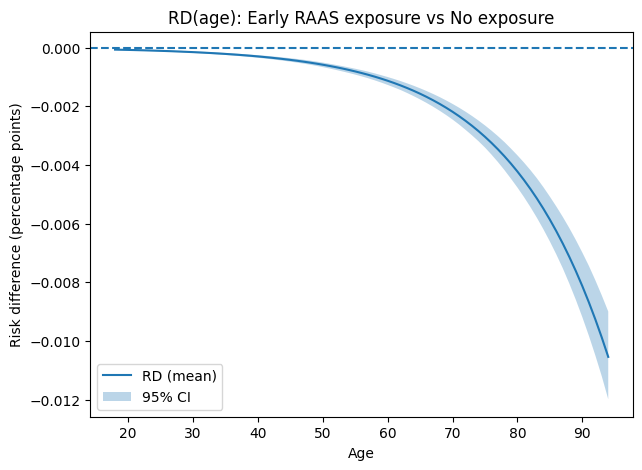

In [20]:
# RD(age) line
age_grid = np.arange(18, 95)
rd_age = compute_rd_by_age(clf, X, age_grid)

# bootstrap CI band
rd_boot = bootstrap_rd_by_age(df, cat_vars, num_vars, age_grid, n_boot=200, seed=42)
rd_mean = rd_boot.mean(axis=0)
rd_lo = np.percentile(rd_boot, 2.5, axis=0)
rd_hi = np.percentile(rd_boot, 97.5, axis=0)

# IMPORTANT: line and band are aligned because they come from the same estimator
rd_line = rd_mean


# plot in percentage points
plt.figure(figsize=(7, 5))
plt.plot(age_grid, rd_line, label="RD (mean)")
plt.fill_between(age_grid, rd_lo, rd_hi, alpha=0.3, label="95% CI")
plt.axhline(0, linestyle="--")
plt.title("RD(age): Early RAAS exposure vs No exposure")
plt.xlabel("Age")
plt.ylabel("Risk difference (percentage points)")
plt.legend()
plt.show()

**Interpretation**

- Early RAAS exposure was associated with a lower adjusted mortality risk across all ages.
- The absolute risk reduction increased progressively with age.
- The 95% bootstrap confidence intervals remained below zero across most of the age range.

## 5. Discussion

In this multivariable analysis of a large non-ICU hospitalized cohort, early exposure to renin–angiotensin–aldosterone system (RAAS) inhibitors was consistently associated with lower in-hospital mortality across multiple complementary effect measures.

After adjustment for demographic characteristics, admission-related factors, insurance status, and calendar time, early RAAS exposure demonstrated a protective association that was robust across modeling approaches. Importantly, this association was evident not only on the relative scale using odds ratios, but also on the absolute risk scale through average marginal effects and age-specific risk differences.

By focusing on marginal effects, this analysis provides clinically interpretable estimates of absolute risk reduction that complement traditional odds ratios. While odds ratios are commonly reported in observational studies, they can be difficult to translate into clinical decision-making, particularly when outcomes are rare. In contrast, marginal effects and risk differences directly quantify changes in predicted mortality risk and are therefore more intuitive for clinicians and policy stakeholders.

Age-specific analyses further suggested that the association between early RAAS exposure and mortality was stable across the adult age spectrum. Adjusted predicted mortality increased with age in both exposure groups, reflecting the dominant role of age as a risk factor. However, the absolute separation between exposure groups widened with increasing age, indicating larger absolute risk differences among older patients. The consistency of effect direction across ages supports the robustness of the observed association.

From a methodological perspective, this study illustrates how multivariable logistic regression can be extended beyond coefficient-level interpretation to yield risk-based measures with direct clinical relevance. The use of bootstrap resampling to quantify uncertainty in derived quantities, such as marginal effects and age-specific risk differences, further strengthens the reliability of these estimates without relying on asymptotic assumptions.

Several limitations warrant consideration. As an observational study, the findings represent associations rather than causal effects, and residual confounding by unmeasured factors cannot be excluded. Early RAAS exposure was defined based on in-hospital medication records and does not capture outpatient treatment history, adherence, or post-admission treatment changes. In addition, all predicted risks and marginal effects are model-based and depend on correct model specification.

Despite these limitations, the consistency of findings across multiple effect measures and analytical approaches supports the credibility of the observed association. Future studies using causal inference frameworks, such as target trial emulation or instrumental variable methods, may help clarify the causal role of early RAAS inhibitor use in hospitalized populations.